In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

In [2]:
n = 50

x1 = np.random.normal(3, 1.25, n)
y1 = np.random.normal(2, 1.25, n)

x2 = np.random.normal(7, 1.25, n)
y2 = np.random.normal(5, 1.25, n)

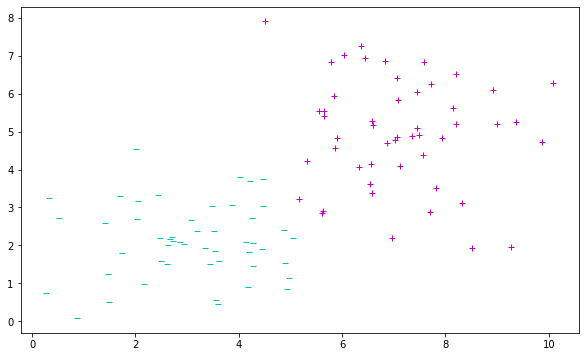

In [3]:
plt.figure(figsize = (10,6))

plt.plot(x1, y1, 'c_')
plt.plot(x2, y2, 'm+')

In [4]:
x = np.append(x1, [x2])
y = np.append(y1, [y2])
c = np.append(np.full(x1.shape, -1), [np.full(x2.shape, 1)])

In [5]:
x[0], y[0], c[0]

(2.7346375956376026, 2.113653891305008, -1)

In [6]:
df = pd.DataFrame(list(zip(x, y, c)), columns =['x', 'y', 'c']) 
df.iloc[0]

x    2.734638
y    2.113654
c   -1.000000
Name: 0, dtype: float64

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['c'], axis = 1), df['c'], test_size=0.2, stratify = df['c'])
y_train

89    1
64    1
27   -1
58    1
76    1
     ..
79    1
22   -1
4    -1
61    1
44   -1
Name: c, Length: 80, dtype: int64

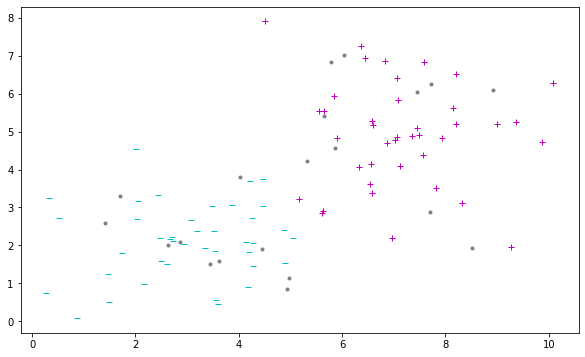

In [8]:
plt.figure(figsize = (10,6))

plt.plot(X_train.loc[y_train == -1, 'x'], X_train.loc[y_train == -1, 'y'], 'c_')
plt.plot(X_train.loc[y_train == 1, 'x'], X_train.loc[y_train == 1, 'y'], 'm+')

plt.plot(X_test['x'], X_test['y'], '.', color = 'gray')

In [9]:
!pip install cvxopt

In [10]:
from cvxopt import solvers, matrix
solvers.options['show_progress'] = False

class SVM:
    def __init__(self, C = None):
        self.C = C
        self.kernel = lambda x1, x2: np.dot(x1, x2)
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        n_samples = self.X.shape[0]
        n_features = len(self.X.columns)
        
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(self.X.iloc[i], self.X.iloc[j])
                
        P = matrix(np.outer(self.y, self.y) * K)
        q = matrix(np.ones(n_samples) * -1)
        
        if not self.C:
            G = matrix(np.identity(n_samples) * -1)
            h = matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            
            G = matrix(np.vstack((G_max, G_min)))
            
            h_max = matrix(np.zeros(n_samples))
            h_min = matrix(np.ones(n_samples) * self.C)
            
            h = matrix(np.vstack((h_max, h_min)))
        
        A = matrix(self.y.astype(float), (1, n_samples))
        b = matrix(0.0)
        
        solution = solvers.qp(P, q, G, h, A, b)
        
        a = np.ravel(solution['x'])
        
        support_vec = a > 1e-5
        ind = np.arange(len(a))[support_vec]
        self.a = a[support_vec]
        
        self.support_vec = self.X[support_vec]
        self.support_vec_y = self.y[support_vec]
        
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.support_vec_y.iloc[n]
            self.b -= np.sum(self.a * self.support_vec_y * K[ind[n], support_vec])
        self.b /= len(self.a)
        
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
            self.w += self.a[n] * self.support_vec_y.iloc[n] * self.support_vec.iloc[n]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [11]:
clf = SVM()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

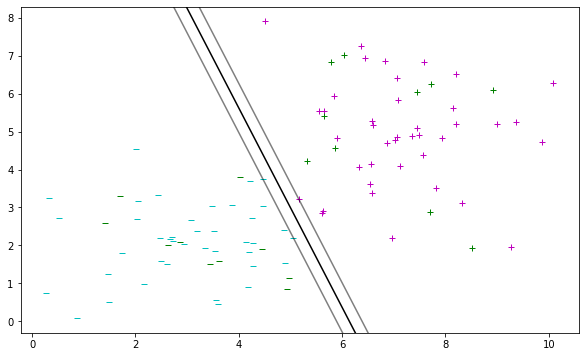

In [12]:
plt.figure(figsize = (10,6))

plt.plot(X_train.loc[y_train == -1, 'x'], X_train.loc[y_train == -1, 'y'], 'c_')
plt.plot(X_train.loc[y_train == 1, 'x'], X_train.loc[y_train == 1, 'y'], 'm+')

plt.plot(X_test.loc[y_test == -1, 'x'][y_test == y_pred], X_test.loc[y_test == -1, 'y'][y_test == y_pred], 'g_')
plt.plot(X_test.loc[y_pred == -1, 'x'][y_test != y_pred], X_test.loc[y_pred == -1, 'y'][y_test != y_pred], 'r_')
plt.plot(X_test.loc[y_test == 1, 'x'][y_test == y_pred], X_test.loc[y_test == 1, 'y'][y_test == y_pred], 'g+')
plt.plot(X_test.loc[y_pred == 1, 'x'][y_test != y_pred], X_test.loc[y_pred == 1, 'y'][y_test != y_pred], 'r+')

x1, x2 = plt.axis('tight')[0], plt.axis('tight')[1]
y1 = (-clf.w[0] * x1 - clf.b) / clf.w[1] 
y2 = (-clf.w[0] * x2 - clf.b) / clf.w[1]
plt.plot([x1, x2], [y1, y2], "k")
        
y1 = (-clf.w[0] * x1 - clf.b + 1) / clf.w[1]
y2 = (-clf.w[0] * x2 - clf.b + 1) / clf.w[1]
plt.plot([x1, x2], [y1, y2], "k", alpha = 0.5)
        
y1 = (-clf.w[0] * x1 - clf.b - 1) / clf.w[1]
y2 = (-clf.w[0] * x2 - clf.b - 1) / clf.w[1]
plt.plot([x1, x2], [y1, y2], "k", alpha = 0.5)

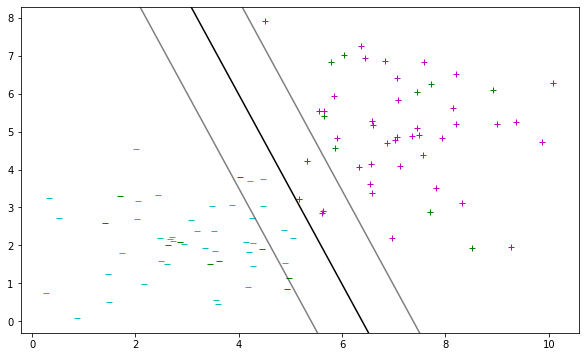

In [13]:
clf = SVM(C = 0.5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

plt.figure(figsize = (10,6))

plt.plot(X_train.loc[y_train == -1, 'x'], X_train.loc[y_train == -1, 'y'], 'c_')
plt.plot(X_train.loc[y_train == 1, 'x'], X_train.loc[y_train == 1, 'y'], 'm+')

plt.plot(X_test.loc[y_test == -1, 'x'][y_test == y_pred], X_test.loc[y_test == -1, 'y'][y_test == y_pred], 'g_')
plt.plot(X_test.loc[y_pred == -1, 'x'][y_test != y_pred], X_test.loc[y_pred == -1, 'y'][y_test != y_pred], 'r_')
plt.plot(X_test.loc[y_test == 1, 'x'][y_test == y_pred], X_test.loc[y_test == 1, 'y'][y_test == y_pred], 'g+')
plt.plot(X_test.loc[y_pred == 1, 'x'][y_test != y_pred], X_test.loc[y_pred == 1, 'y'][y_test != y_pred], 'r+')

x1, x2 = plt.axis('tight')[0], plt.axis('tight')[1]
y1 = (-clf.w[0] * x1 - clf.b) / clf.w[1] 
y2 = (-clf.w[0] * x2 - clf.b) / clf.w[1]
plt.plot([x1, x2], [y1, y2], "k")
        
y1 = (-clf.w[0] * x1 - clf.b + 1) / clf.w[1]
y2 = (-clf.w[0] * x2 - clf.b + 1) / clf.w[1]
plt.plot([x1, x2], [y1, y2], "k", alpha = 0.5)
        
y1 = (-clf.w[0] * x1 - clf.b - 1) / clf.w[1]
y2 = (-clf.w[0] * x2 - clf.b - 1) / clf.w[1]
plt.plot([x1, x2], [y1, y2], "k", alpha = 0.5)